In [ ]:
import tensorflow as tf

from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
print("Tensorflow version " + tf.__version__)
import os
import pathlib
import PIL
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers

Tensorflow version 2.7.0


In [ ]:
from zipfile import ZipFile

train_zip = 'drive/MyDrive/Datasets/traindata.zip'
val_zip = 'drive/MyDrive/Datasets/val_data.zip'
test_zip = 'drive/MyDrive/Datasets/test_data.zip'

# with ZipFile(train_zip, 'r') as zip:
#   zip.extractall("train_photos")

# with ZipFile(val_zip, 'r') as zip:
#   zip.extractall("val_photos")

with ZipFile(test_zip, 'r') as zip:
  zip.extractall("test_photos")
  
# train_dir = os.path.join("./", 'train_photos')
# val_dir = os.path.join("./", 'val_photos')
test_dir = os.path.join("./", 'test_photos')

# data_dir = pathlib.Path(train_dir)


# free = list(data_dir.glob('free/*'))
# PIL.Image.open(str(free[2]))

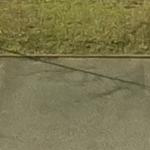

In [ ]:
data_dir = pathlib.Path(test_dir)
free = list(data_dir.glob('free/*'))
PIL.Image.open(str(free[5]))

In [ ]:
!ls
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

drive  sample_data  test_photos  train_photos  val_photos
31825


In [ ]:
import tensorflow_hub as hub

# module = hub.load("https://tfhub.dev/tensorflow/efficientnet/lite0/feature-vector/2")
# input_shape = image.shape
# warmup_input = tf.random.uniform(input_shape, 0, 1.0)
# %time warmup_logits = module(warmup_input).numpy()


In [ ]:
IMAGE_SIZE = 224
model_name = 'efficientnet-lite0'
model_handle = 'https://tfhub.dev/tensorflow/efficientnet/lite0/feature-vector/2'
pixels = (224)

print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SHAPE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

Selected model: efficientnet-lite0 : https://tfhub.dev/tensorflow/efficientnet/lite0/feature-vector/2
Input size 224


In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 64 #64 cuz apparently needs to be 8? 

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    #make moe brightness generation!
    brightness_range=[0.2,1.0]
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)


val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=(BATCH_SIZE),
    # class_mode='binary'
    class_mode='categorical',
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=(BATCH_SIZE),
    # class_mode='binary'
    class_mode='categorical',
) 

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=(BATCH_SIZE),
    # subset='validation',
    # class_mode='binary'
    class_mode='categorical'
) 

Found 94493 images belonging to 2 classes.
Found 18647 images belonging to 2 classes.
Found 31825 images belonging to 2 classes.


In [ ]:
classes = 2

In [ ]:
print("Building model with", model_handle)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SHAPE + (3,)),
    hub.KerasLayer(model_handle, trainable=False),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(classes,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SHAPE+(3,))
model.summary()


Building model with https://tfhub.dev/tensorflow/efficientnet/lite0/feature-vector/2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              3413024   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 3,415,586
Trainable params: 2,562
Non-trainable params: 3,413,024
_________________________________________________________________


In [ ]:
checkpoint_path = "weights.{epoch:02d}-{val_loss:.2f}.hdf5"                             
cp_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path, verbose=1, save_weights_only=True,
        period=1)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2, restore_best_weights=True)

rlrop = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience= 1, factor= 0.5, min_lr= 1e-15, verbose=1)


In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.0005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

# steps_per_epoch = len() // BATCH_SIZE
# validation_steps = valid_size // BATCH_SIZE
hist = model.fit(
    train_generator,
    epochs=5, 
    # steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    callbacks=[early_stop, rlrop,cp_callback],).history
    # validation_steps=validation_steps).history


Epoch 1/5
1477/1477 [==============================] - ETA: 0s - loss: 0.2789 - accuracy: 0.9623
Epoch 00001: saving model to weights.01-0.26.hdf5
1477/1477 [==============================] - 1230s 825ms/step - loss: 0.2789 - accuracy: 0.9623 - val_loss: 0.2638 - val_accuracy: 0.9693 - lr: 5.0000e-04
Epoch 2/5
1477/1477 [==============================] - ETA: 0s - loss: 0.2566 - accuracy: 0.9757
Epoch 00002: saving model to weights.02-0.26.hdf5
1477/1477 [==============================] - 1214s 822ms/step - loss: 0.2566 - accuracy: 0.9757 - val_loss: 0.2563 - val_accuracy: 0.9726 - lr: 5.0000e-04
Epoch 3/5
1477/1477 [==============================] - ETA: 0s - loss: 0.2513 - accuracy: 0.9783
Epoch 00003: saving model to weights.03-0.25.hdf5
1477/1477 [==============================] - 1212s 821ms/step - loss: 0.2513 - accuracy: 0.9783 - val_loss: 0.2510 - val_accuracy: 0.9757 - lr: 5.0000e-04
Epoch 4/5
 685/1477 [============>.................] - ETA: 10:24 - loss: 0.2498 - accuracy: 0

In [ ]:
def plot_hist(hist):
    # plt.plot(hist.history["accuracy"])
    # plt.plot(hist.history["val_accuracy"])
    # plt.title("model accuracy")
    # plt.ylabel("accuracy")
    
    # plt.xlabel("epoch")
    # plt.legend(["train", "validation"], loc="upper left")
    # plt.show()
    # plt.figure(figsize=(18,8))


    plt.suptitle('Loss and Accuracy Plots', fontsize=18)

    plt.subplot(1,2,1)
    plt.plot(hist['loss'], label='Training Loss')
    plt.plot(hist['val_loss'], label='Validation Loss')
    plt.legend()
    plt.xlabel('Number of epochs', fontsize=15)
    plt.ylabel('Loss', fontsize=15)


    plt.subplot(1,2,2)
    plt.plot(hist['accuracy'], label='Train Accuracy')
    plt.plot(hist['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.xlabel('Number of epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.show()

plot_hist(hist)

In [ ]:
def representative_data_gen():
  dataset_list = tf.data.Dataset.list_files(park_dir + '/*/*')
  for i in range(100):
    image = next(iter(dataset_list))
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image = tf.cast(image / 255., tf.float32)
    image = tf.expand_dims(image, 0)
    yield [image]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
# This enables quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# This sets the representative dataset for quantization
converter.representative_dataset = representative_data_gen
# This ensures that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# For full integer quantization, though supported types defaults to int8 only, we explicitly declare it for clarity.
converter.target_spec.supported_types = [tf.int8]
# These set the input and output tensors to uint8 (added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_model = converter.convert()

with open('effnetlite_v2.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
batch_images, batch_labels = next(val_generator)

logits = model(batch_images)
prediction = np.argmax(logits, axis=1)
truth = np.argmax(batch_labels, axis=1)

keras_accuracy = tf.keras.metrics.Accuracy()
keras_accuracy(prediction, truth)

print("Raw model accuracy: {:.3%}".format(keras_accuracy.result()))


In [ ]:
c = 0

In [ ]:
def set_input_tensor(interpreter, input):
  input_details = interpreter.get_input_details()[0]
  tensor_index = input_details['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  # Inputs for the TFLite model must be uint8, so we quantize our input data.
  # NOTE: This step is necessary only because we're receiving input data from
  # ImageDataGenerator, which rescaled all image data to float [0,1]. When using
  # bitmap inputs, they're already uint8 [0,255] so this can be replaced with:
  input_tensor[:, :] = input
  scale, zero_point = input_details['quantization']
  input_tensor[:, :] = np.uint8(input / scale + zero_point)

def classify_image(interpreter, input,):
  set_input_tensor(interpreter, input)
  interpreter.invoke()
  output_details = interpreter.get_output_details()[0]
  output = interpreter.get_tensor(output_details['index'])
  # print(batch_truth[c])
  # Outputs from the TFLite model are uint8, so we dequantize the results:
  scale, zero_point = output_details['quantization']
  output = scale * (output - zero_point)
  top_1 = np.argmin(output) #np.argmax(output)
  # print(top_1)
  return top_1

interpreter = tf.lite.Interpreter('effnetlite_v2.tflite')
interpreter.allocate_tensors()

# Collect all inference predictions in a list
batch_prediction = []
batch_truth = np.argmax(batch_labels, axis=1)

c=0
for i in range(len(batch_images)):
  prediction = classify_image(interpreter, batch_images[i])
  batch_prediction.append(prediction)

# Compare all predictions to the ground truth
tflite_accuracy = tf.keras.metrics.Accuracy()
tflite_accuracy(batch_prediction, batch_truth)
print("Quant TF Lite accuracy: {:.3%}".format(tflite_accuracy.result()))

In [ ]:
! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

! echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list

! sudo apt-get update

! sudo apt-get install edgetpu-compiler	

In [ ]:
! edgetpu_compiler effnetlite_v2.tflite

In [ ]:
from google.colab import files

files.download('effnetlite_v2.tflite')
files.download('effnetlite_v2_edgetpu.tflite')
# files.download('lot_labels.txt')

In [ ]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('lot_labels.txt', 'w') as f:
  f.write(labels)

In [ ]:
image_batch, label_batch = next(val_generator)
image_batch.shape, label_batch.shape

class_names = sorted(train_generator.class_indices.keys())
# print(label_batch)

plt.figure(figsize=(10, 10))
for images in image_batch:
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i])
    plt.title(class_names[label_batch[i][1].astype('uint8')])
    plt.axis("off")

# import matplotlib.pyplot as plt

# for images, labels in train_ds.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     print(image_batch[i].shape)
#     plt.imshow(image_batch[i])
#     plt.title(labels_batch[i].numpy().astype("String"))
#     plt.title("a")
#     plt.axis("off")
